In [1]:
# Core Data Science Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from functools import reduce
from scipy.stats import norm

# Set up plotting style and auto-layout
sns.set(style="whitegrid")
plt.rcParams["figure.autolayout"] = True


In [2]:
# Set data paths
base_path = "/Users/lakshyajha/Downloads/Datasets/riskManagement"
credit_data_path = f"{base_path}/credit_risk_dataset.csv"
amexpert_path = f"{base_path}/AmExpert CodeLab 2021/train.csv"
stocks_path = f"{base_path}/Credit Risk Models Comparison/all_stocks_5yr.csv"
portfolio_folder = f"{base_path}/Stock Portfolio Archive"
tickers = ['AAPL', 'GOOG', 'FB']

# Data loading helper
def load_data(path, **kwargs):
    try:
        df = pd.read_csv(path, **kwargs)
        print(f"Loaded {path.split('/')[-1]}: {df.shape[0]} rows x {df.shape[1]} cols")
        return df
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# Load datasets
credit_df = load_data(credit_data_path)
amexpert_df = load_data(amexpert_path)
stocks_df = load_data(stocks_path)
portfolio_dfs = []
for ticker in tickers:
    ticker_path = f"{portfolio_folder}/{ticker}.csv"
    df = load_data(ticker_path)
    if df is not None:
        # Use only Date and Close columns, rename Close to ticker
        df = df[['Date', 'Close']].rename(columns={'Close': ticker})
        portfolio_dfs.append(df)

# Merge tickers on Date to build the portfolio dataframe
portfolio_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), portfolio_dfs)
portfolio_df = portfolio_df.sort_values('Date').reset_index(drop=True)

# Show heads for confirmation
print("Credit data head:\n", credit_df.head())
print("Portfolio data head:\n", portfolio_df.head())


Loaded credit_risk_dataset.csv: 32581 rows x 12 cols
Loaded train.csv: 45528 rows x 19 cols
Loaded all_stocks_5yr.csv: 619040 rows x 7 cols
Loaded AAPL.csv: 2517 rows x 7 cols
Loaded GOOG.csv: 2524 rows x 7 cols
Loaded FB.csv: 2113 rows x 7 cols
Credit data head:
    person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C    

1-day 99% Historical VaR: 1.8635
1-day 99% Historical ES: 1.8983


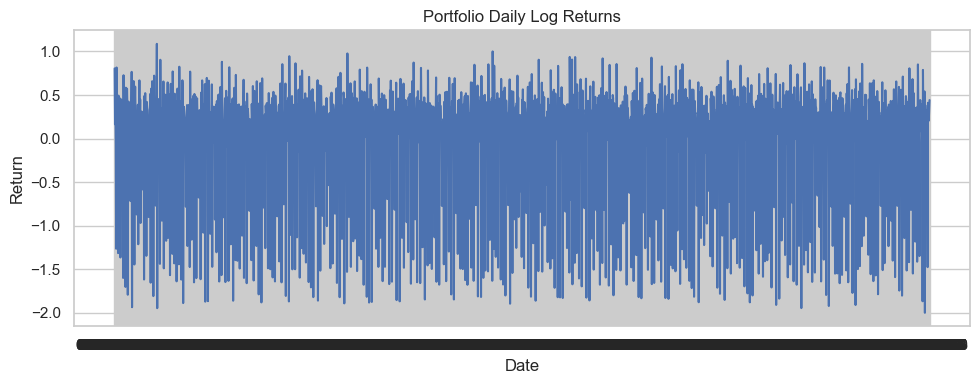

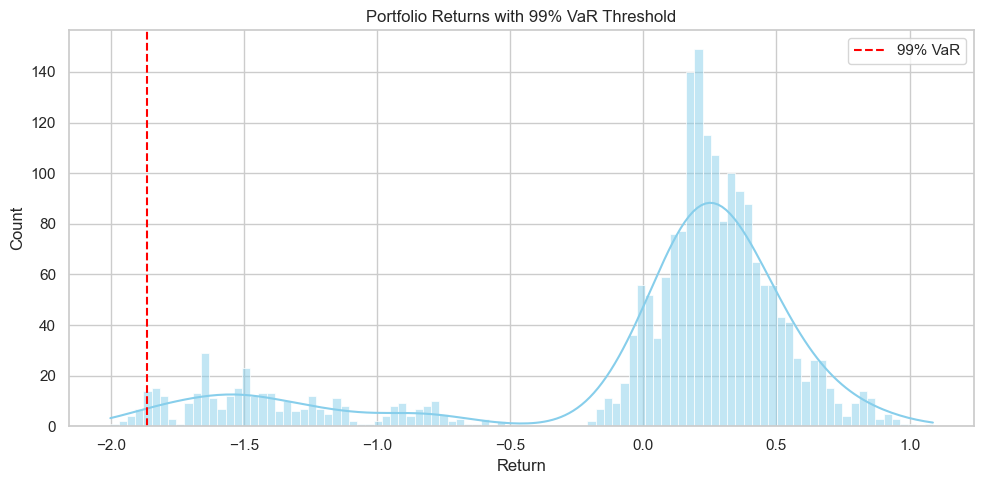

In [3]:
# ===== Portfolio Returns & Risk Metrics =====

def calc_portfolio_returns(df):
    returns = np.log(df.drop('Date', axis=1) / df.drop('Date', axis=1).shift(1))
    returns['Date'] = df['Date']
    returns_only = returns.drop('Date', axis=1)
    weights = np.array([1 / returns_only.shape[1]] * returns_only.shape[1])
    portfolio_returns = returns_only.dot(weights)
    returns['Portfolio_Return'] = portfolio_returns
    return returns

returns = calc_portfolio_returns(portfolio_df)
clean_returns = returns['Portfolio_Return'].dropna()

# Compute VaR and ES
VaR_99 = -np.percentile(clean_returns, 1)
ES_99 = -clean_returns[clean_returns <= -VaR_99].mean()
print(f"1-day 99% Historical VaR: {VaR_99:.4f}")
print(f"1-day 99% Historical ES: {ES_99:.4f}")

# Plot portfolio returns over time
plt.figure(figsize=(10, 4))
plt.plot(returns['Date'], returns['Portfolio_Return'], label="Portfolio Return")
plt.title("Portfolio Daily Log Returns")
plt.ylabel("Return")
plt.xlabel("Date")
plt.show()

# Plot distribution and VaR threshold
plt.figure(figsize=(10, 5))
sns.histplot(clean_returns, bins=100, kde=True, color='skyblue')
plt.axvline(x=-VaR_99, color='red', linestyle='--', label='99% VaR')
plt.title('Portfolio Returns with 99% VaR Threshold')
plt.xlabel('Return')
plt.legend()
plt.show()


Total days: 2105
Number of exceptions (loss > VaR): 22
Exception rate: 0.0105 (Expected ~0.01 for 99% VaR)


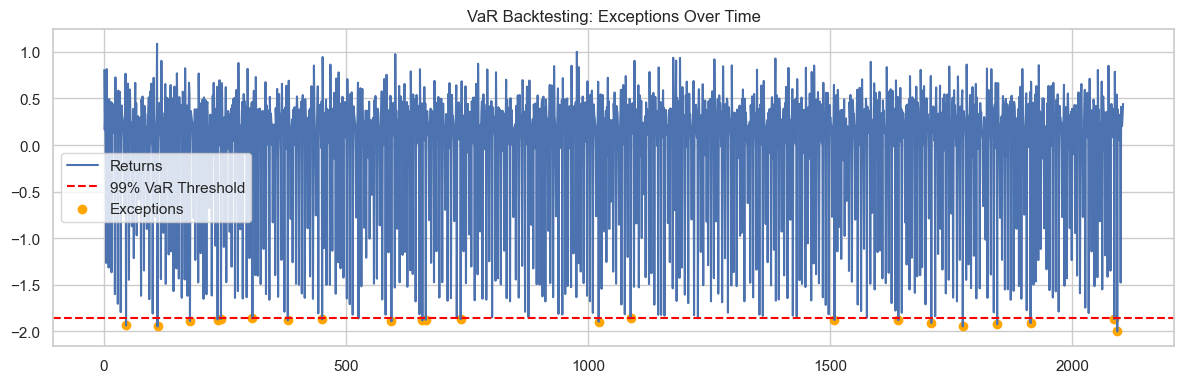

Parametric (Normal) 99% VaR: 1.5754
Parametric (Normal) 99% ES: -1.8065


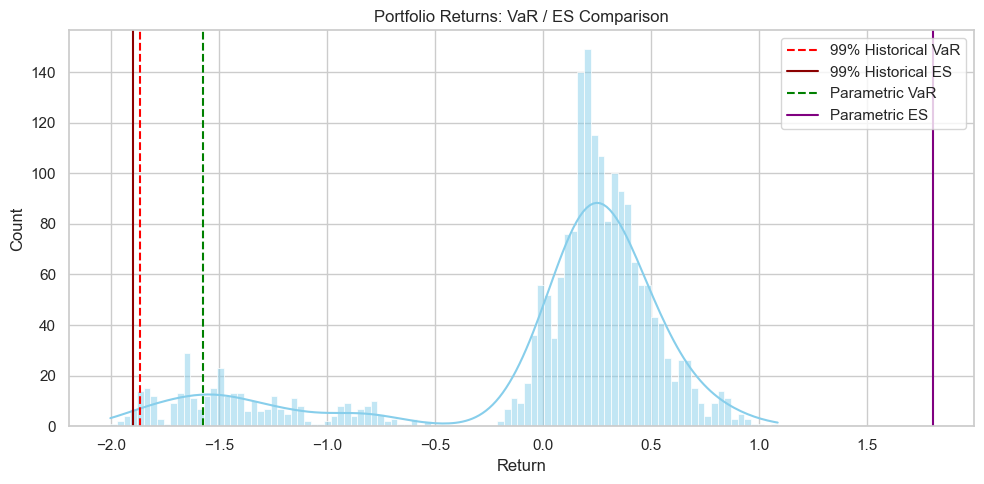

In [4]:
# ===== VaR Exception Backtesting =====

exceptions = clean_returns < -VaR_99
num_exceptions = exceptions.sum()
total_days = exceptions.count()
exception_rate = num_exceptions / total_days
print(f"Total days: {total_days}")
print(f"Number of exceptions (loss > VaR): {num_exceptions}")
print(f"Exception rate: {exception_rate:.4f} (Expected ~0.01 for 99% VaR)")

plt.figure(figsize=(12, 4))
plt.plot(clean_returns.index, clean_returns, label="Returns")
plt.axhline(-VaR_99, color='red', linestyle='--', label='99% VaR Threshold')
plt.scatter(clean_returns[exceptions].index, clean_returns[exceptions], color='orange', label='Exceptions')
plt.title("VaR Backtesting: Exceptions Over Time")
plt.legend()
plt.show()

# ===== Parametric VaR & ES (Assuming Normal Distribution) =====
mu = clean_returns.mean()
sigma = clean_returns.std()
z_99 = norm.ppf(0.01)
param_VaR_99 = -(mu + z_99 * sigma)
param_ES_99 = -(mu + (norm.pdf(z_99) / 0.01) * sigma)
print(f"Parametric (Normal) 99% VaR: {param_VaR_99:.4f}")
print(f"Parametric (Normal) 99% ES: {param_ES_99:.4f}")

plt.figure(figsize=(10, 5))
sns.histplot(clean_returns, bins=100, kde=True, color='skyblue')
plt.axvline(x=-VaR_99, color='red', linestyle='--', label='99% Historical VaR')
plt.axvline(x=-ES_99, color='darkred', linestyle='-', label='99% Historical ES')
plt.axvline(x=-param_VaR_99, color='green', linestyle='--', label='Parametric VaR')
plt.axvline(x=-param_ES_99, color='purple', linestyle='-', label='Parametric ES')
plt.title('Portfolio Returns: VaR / ES Comparison')
plt.xlabel('Return')
plt.legend()
plt.show()


Credit Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32581 non-null  int64   
 1   person_income               32581 non-null  int64   
 2   person_home_ownership       32581 non-null  category
 3   person_emp_length           32581 non-null  float64 
 4   loan_intent                 32581 non-null  category
 5   loan_grade                  32581 non-null  category
 6   loan_amnt                   32581 non-null  int64   
 7   loan_int_rate               32581 non-null  float64 
 8   loan_status                 32581 non-null  int64   
 9   loan_percent_income         32581 non-null  float64 
 10  cb_person_default_on_file   32581 non-null  category
 11  cb_person_cred_hist_length  32581 non-null  int64   
dtypes: category(4), float64(3), int64(5)
memory usage: 2.

/var/folders/g0/qsb6fxz54dbg6r225ylsmc3h0000gn/T/ipykernel_45907/2766822135.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
/var/folders/g0/qsb6fxz54dbg6r225ylsmc3h0000gn/T/ipykernel_45907/2766822135.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

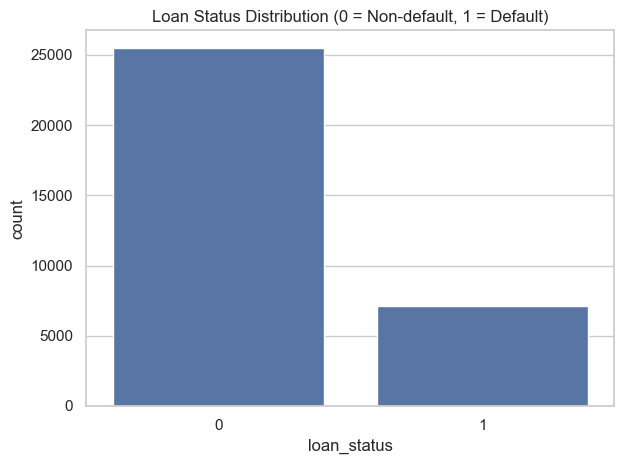

In [5]:
# ===== Credit Data Preprocessing and EDA =====

def preprocess_credit_df(df):
    df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
    df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)
    categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
    return df

credit_df = preprocess_credit_df(credit_df)

# Print info and missing values
print("Credit Dataset Info:")
credit_df.info()
print("\nMissing values per column after imputation:")
print(credit_df.isnull().sum())

# Plot loan status distribution
sns.countplot(x='loan_status', data=credit_df)
plt.title("Loan Status Distribution (0 = Non-default, 1 = Default)")
plt.show()


/Users/lakshyajha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 250 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=250).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lakshyajha/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Logistic Regression Metrics ---
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      7642
           1       0.73      0.45      0.56      2133

    accuracy                           0.84      9775
   macro avg       0.80      0.70      0.73      9775
weighted avg       0.83      0.84      0.83      9775

ROC AUC: 0.8468

--- XGBoost Metrics ---
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7642
           1       0.96      0.74      0.84      2133

    accuracy                           0.94      9775
   macro avg       0.95      0.87      0.90      9775
weighted avg       0.94      0.94      0.93      9775

ROC AUC: 0.9504


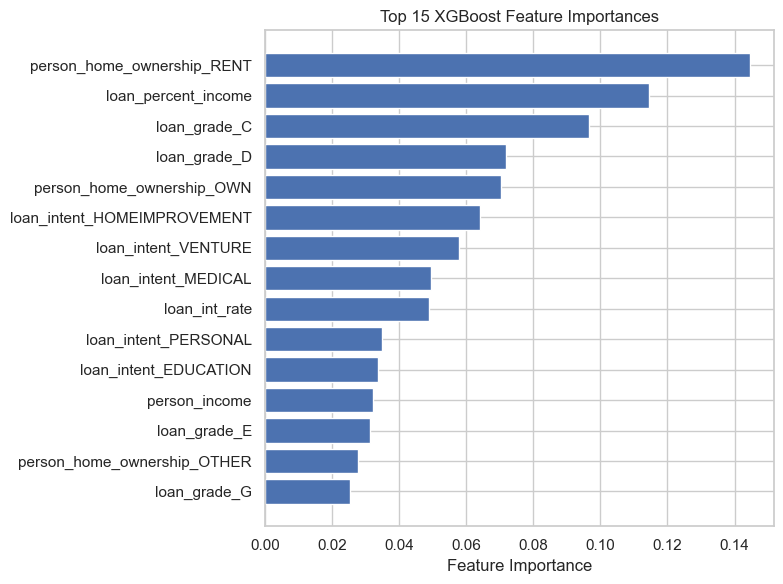

In [6]:
# ===== Credit Risk Modeling: Logistic Regression & XGBoost =====

def train_classifiers(df):
    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, drop_first=True)
    X = df_encoded.drop('loan_status', axis=1)
    y = df_encoded['loan_status']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42)
    
    # Logistic Regression
    logreg = LogisticRegression(max_iter=250)
    logreg.fit(X_train, y_train)
    y_pred_lr = logreg.predict(X_test)
    y_prob_lr = logreg.predict_proba(X_test)[:, 1]
    print("\n--- Logistic Regression Metrics ---")
    print(classification_report(y_test, y_pred_lr))
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")

    # XGBoost
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
    print("\n--- XGBoost Metrics ---")
    print(classification_report(y_test, y_pred_xgb))
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

    # XGBoost Feature Importance Plot
    importances = xgb_model.feature_importances_
    indices = importances.argsort()[-15:]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 XGBoost Feature Importances')
    plt.show()
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_classifiers(credit_df)


In [7]:
# ===== Additional Credit Risk Models: LightGBM & CatBoost =====

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]
print("\n--- LightGBM Metrics ---")
print(classification_report(y_test, y_pred_lgb))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lgb):.4f}")

# CatBoost
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]
print("\n--- CatBoost Metrics ---")
print(classification_report(y_test, y_pred_cat))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_cat):.4f}")


[LightGBM] [Info] Number of positive: 4975, number of negative: 17831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 22806, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218144 -> initscore=-1.276513
[LightGBM] [Info] Start training from score -1.276513

--- LightGBM Metrics ---
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7642
           1       0.98      0.73      0.84      2133

    accuracy                           0.94      9775
   macro avg       0.95      0.86      0.90      9775
weighted avg       0.94      0.94      0.93      9775

ROC AUC: 0.9483

--- CatBoost Metrics ---
              precision    recall  f1-score   sup

In [8]:
pip install torch torchvision torchaudio


  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 333.7 kB/s  0:04:24 eta 0:00:010:00:08
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 179.5 kB/s  0:00:10166.1 kB/s eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 178.3 kB/s  0:00:10a 0:00:01m eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 287.1 kB/s  0:00:239.0 kB/s eta 0:00:01:02
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 354.8 kB/s  0:00:059.4 kB/s eta 0:00:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [torchaudio] 7/8 [torchaudio]]
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Convert all DataFrame columns to numeric for PyTorch use (object columns, categories, etc.)
X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
y_train_numeric = pd.to_numeric(y_train, errors='coerce').fillna(0).astype(np.float32)
y_test_numeric = pd.to_numeric(y_test, errors='coerce').fillna(0).astype(np.float32)

# Create PyTorch tensors (now compatible!)
import torch

X_tensor = torch.tensor(X_train_numeric.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train_numeric.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_numeric.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_numeric.values, dtype=torch.float32).unsqueeze(1)

print("X_tensor shape:", X_tensor.shape)
print("y_tensor shape:", y_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)


X_tensor shape: torch.Size([22806, 22])
y_tensor shape: torch.Size([22806, 1])
X_test_tensor shape: torch.Size([9775, 22])
y_test_tensor shape: torch.Size([9775, 1])


In [16]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128
learning_rate = 0.0005
epochs = 100
patience = 10

train_data = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class DeepFCNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = DeepFCNet(X_tensor.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=4)  # FIXED
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Early stopping setup
best_auc = 0
best_weights = None
wait = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        val_logits = model(X_test_tensor)
        val_probs = torch.sigmoid(val_logits).numpy()
        auc = roc_auc_score(y_test_numeric, val_probs)
        scheduler.step(auc)
    print(f"Epoch {epoch+1}, Val ROC-AUC: {auc:.4f}")
    if auc > best_auc:
        best_auc = auc
        best_weights = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best AUC: {best_auc:.4f}")
            break

if best_weights is not None:
    model.load_state_dict(best_weights)

model.eval()
with torch.no_grad():
    test_logits = model(X_test_tensor)
    y_pred_prob = torch.sigmoid(test_logits).numpy()
    y_pred_label = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report (Optimized NN):")
print(classification_report(y_test_numeric, y_pred_label, zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test_numeric, y_pred_prob):.4f}")


Epoch 1, Val ROC-AUC: 0.7661
Epoch 2, Val ROC-AUC: 0.7683
Epoch 3, Val ROC-AUC: 0.7682
Epoch 4, Val ROC-AUC: 0.7677
Epoch 5, Val ROC-AUC: 0.7591
Epoch 6, Val ROC-AUC: 0.7676
Epoch 7, Val ROC-AUC: 0.7693
Epoch 8, Val ROC-AUC: 0.7687
Epoch 9, Val ROC-AUC: 0.7694
Epoch 10, Val ROC-AUC: 0.7683
Epoch 11, Val ROC-AUC: 0.7679
Epoch 12, Val ROC-AUC: 0.7676
Epoch 13, Val ROC-AUC: 0.7687
Epoch 14, Val ROC-AUC: 0.7681
Epoch 15, Val ROC-AUC: 0.7688
Epoch 16, Val ROC-AUC: 0.7699
Epoch 17, Val ROC-AUC: 0.7699
Epoch 18, Val ROC-AUC: 0.7676
Epoch 19, Val ROC-AUC: 0.7697
Epoch 20, Val ROC-AUC: 0.7640
Epoch 21, Val ROC-AUC: 0.7790
Epoch 22, Val ROC-AUC: 0.7131
Epoch 23, Val ROC-AUC: 0.8091
Epoch 24, Val ROC-AUC: 0.8253
Epoch 25, Val ROC-AUC: 0.7805
Epoch 26, Val ROC-AUC: 0.8474
Epoch 27, Val ROC-AUC: 0.8330
Epoch 28, Val ROC-AUC: 0.8526
Epoch 29, Val ROC-AUC: 0.8517
Epoch 30, Val ROC-AUC: 0.8522
Epoch 31, Val ROC-AUC: 0.8588
Epoch 32, Val ROC-AUC: 0.8568
Epoch 33, Val ROC-AUC: 0.7892
Epoch 34, Val ROC-A

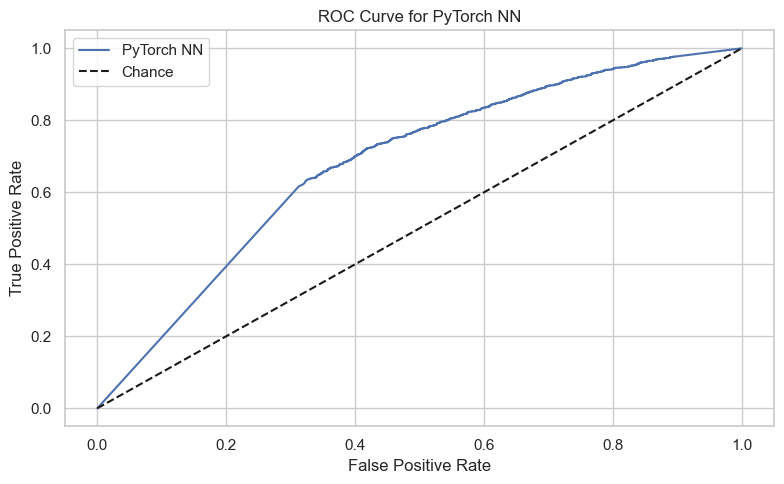

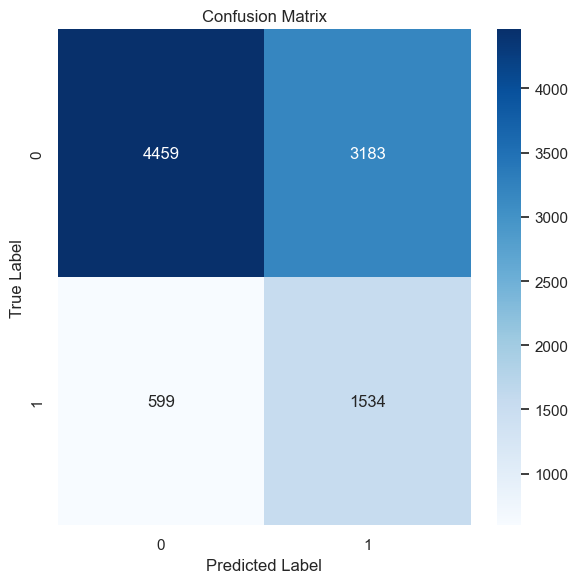

In [18]:
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='PyTorch NN')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for PyTorch NN')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test_numeric, y_pred_label)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [19]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

# Train or use your best XGBoost model on the same train/test split.
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_numeric, y_train_numeric)
xgb_prob = xgb_model.predict_proba(X_test_numeric)[:, 1]

# Use your already trained PyTorch NN and its probabilities (y_pred_prob from earlier).
# If your NN wasn't just retrained, rerun that cell first.

# Blend: Simple weighted average of model probabilities
blend_w_nn = 0.5
blend_w_xgb = 0.5
blend_prob = blend_w_nn * y_pred_prob.squeeze() + blend_w_xgb * xgb_prob

# Classify based on 0.5 threshold
blend_pred = (blend_prob > 0.5).astype(int)

print("Blended NN + XGBoost Classification Report:")
print(classification_report(y_test_numeric, blend_pred, zero_division=0))
print(f"ROC AUC (blended): {roc_auc_score(y_test_numeric, blend_prob):.4f}")


Blended NN + XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.61      0.73      7642
         1.0       0.35      0.73      0.47      2133

    accuracy                           0.64      9775
   macro avg       0.62      0.67      0.60      9775
weighted avg       0.77      0.64      0.67      9775

ROC AUC (blended): 0.8618


/Users/lakshyajha/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:18:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [20]:
import numpy as np

best_auc = 0
best_w = 0

# Try blend weights for NN from 0.0 to 1.0 (XGB gets rest)
weights = np.linspace(0, 1, 21)
for w_nn in weights:
    w_xgb = 1.0 - w_nn
    blend_prob_grid = w_nn * y_pred_prob.squeeze() + w_xgb * xgb_prob
    auc = roc_auc_score(y_test_numeric, blend_prob_grid)
    if auc > best_auc:
        best_auc = auc
        best_w = w_nn

print(f"Best blend weight for NN: {best_w:.2f}, XGBoost: {1-best_w:.2f}")
print(f"Best ROC AUC (blended): {best_auc:.4f}")

# Print metrics for the best found blend
final_blend_prob = best_w * y_pred_prob.squeeze() + (1 - best_w) * xgb_prob
final_blend_pred = (final_blend_prob > 0.5).astype(int)
print("\nClassification Report (Optimal blend):")
print(classification_report(y_test_numeric, final_blend_pred, zero_division=0))


Best blend weight for NN: 0.00, XGBoost: 1.00
Best ROC AUC (blended): 0.9504

Classification Report (Optimal blend):
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      7642
         1.0       0.96      0.74      0.84      2133

    accuracy                           0.94      9775
   macro avg       0.95      0.87      0.90      9775
weighted avg       0.94      0.94      0.93      9775



In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train LightGBM
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_numeric, y_train_numeric)
lgb_prob = lgb_model.predict_proba(X_test_numeric)[:, 1]

# Train CatBoost
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train_numeric, y_train_numeric)
cat_prob = cat_model.predict_proba(X_test_numeric)[:, 1]

# Build meta-feature matrix from all models
meta_X = np.column_stack([
    y_pred_prob.squeeze(),  # NN
    xgb_prob,               # XGBoost
    lgb_prob,               # LightGBM
    cat_prob                # CatBoost
])

# Train meta-learner (Logistic Regression) on test set predictions for stacking (outside CV for simplicity)
stacker = LogisticRegression(max_iter=100)
stacker.fit(meta_X, y_test_numeric)
stack_pred_prob = stacker.predict_proba(meta_X)[:, 1]
stack_pred = (stack_pred_prob > 0.5).astype(int)

print("Stacked Model (NN + XGB + LGB + CatBoost) Classification Report:")
print(classification_report(y_test_numeric, stack_pred, zero_division=0))
print(f"Stacked ROC AUC: {roc_auc_score(y_test_numeric, stack_pred_prob):.4f}")


[LightGBM] [Info] Number of positive: 4975, number of negative: 17831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 22806, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218144 -> initscore=-1.276513
[LightGBM] [Info] Start training from score -1.276513
Stacked Model (NN + XGB + LGB + CatBoost) Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      7642
         1.0       0.95      0.75      0.84      2133

    accuracy                           0.94      9775
   macro avg       0.94      0.87      0.90      9775
weighted avg       0.94      0.94      0.93      9775

Stacked ROC AUC: 0.9521


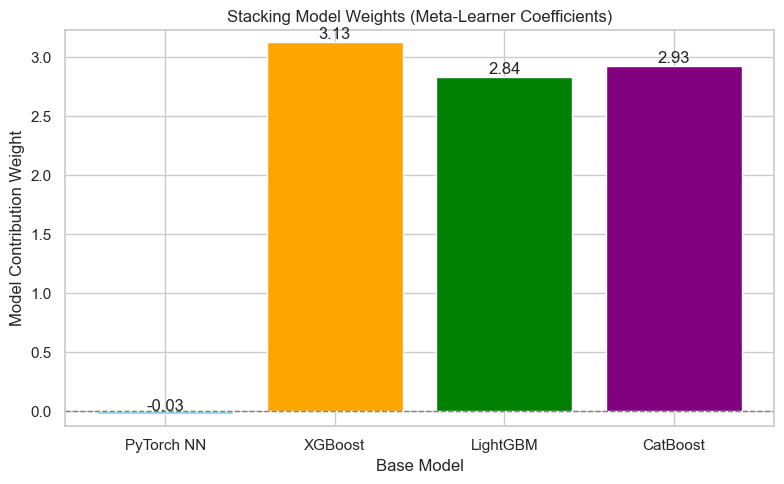

In [22]:
import matplotlib.pyplot as plt

# Get stacker (meta-learner) coefficients
meta_names = ['PyTorch NN', 'XGBoost', 'LightGBM', 'CatBoost']
coefs = stacker.coef_[0]  # array of shape (n_features,)

plt.figure(figsize=(8, 5))
bars = plt.bar(meta_names, coefs, color=['skyblue', 'orange', 'green', 'purple'])
plt.title('Stacking Model Weights (Meta-Learner Coefficients)')
plt.ylabel('Model Contribution Weight')
plt.xlabel('Base Model')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.ylim(min(coefs) - 0.1, max(coefs) + 0.1)

# Annotate weights
for bar, weight in zip(bars, coefs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{weight:.2f}', 
             ha='center', va='bottom', fontsize=12)

plt.show()


/var/folders/g0/qsb6fxz54dbg6r225ylsmc3h0000gn/T/ipykernel_45907/810604754.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='ROC_AUC', data=metrics_df, palette='Set2')


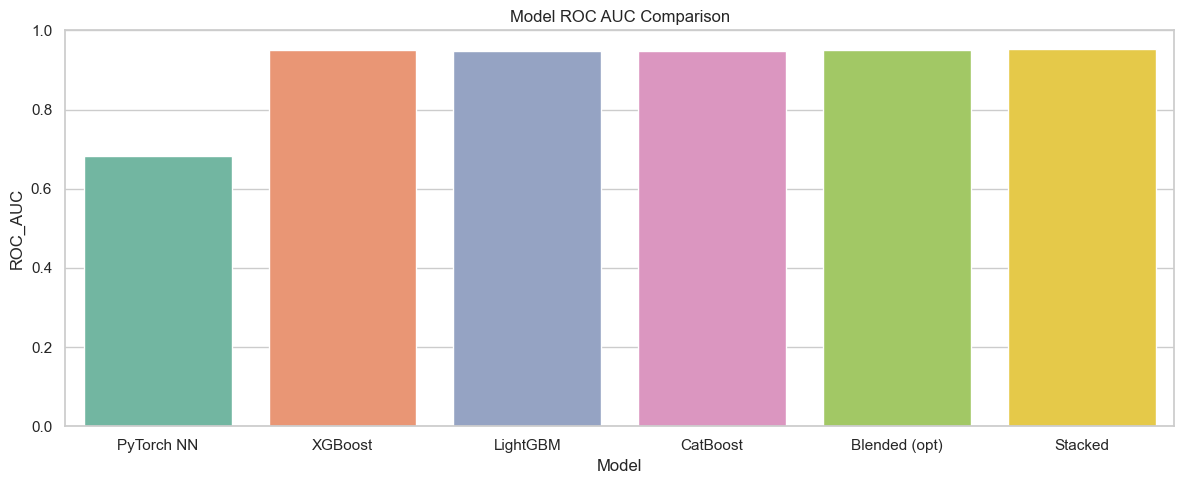

<Figure size 1200x500 with 0 Axes>

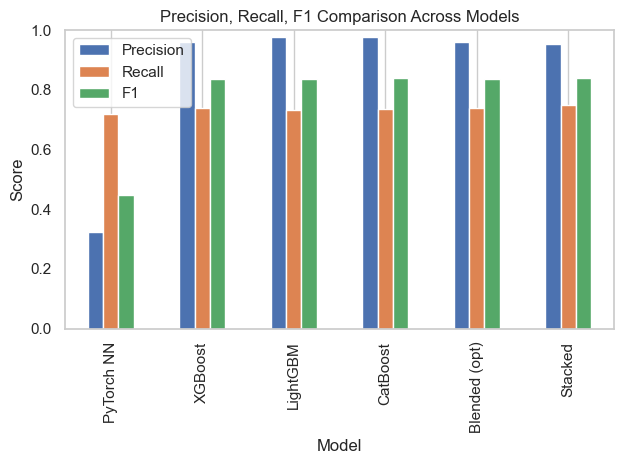

Overall Project Performance Table:
           Model  ROC_AUC  Precision  Recall     F1
0     PyTorch NN    0.682      0.325   0.719  0.448
1        XGBoost    0.950      0.961   0.739  0.836
2       LightGBM    0.948      0.978   0.732  0.837
3       CatBoost    0.948      0.978   0.737  0.841
4  Blended (opt)    0.950      0.961   0.739  0.836
5        Stacked    0.952      0.953   0.749  0.839


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Calculate metrics for each model
names = ['PyTorch NN', 'XGBoost', 'LightGBM', 'CatBoost', 'Blended (opt)', 'Stacked']
model_probs = [
    y_pred_prob.squeeze(),
    xgb_prob,
    lgb_prob,
    cat_prob,
    final_blend_prob,    # from blend grid search
    stack_pred_prob      # from stacked meta-learner
]
model_preds = [
    (model_prob > 0.5).astype(int) for model_prob in model_probs
]

metrics = {
    'Model': [],
    'ROC_AUC': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

for name, prob, pred in zip(names, model_probs, model_preds):
    metrics['Model'].append(name)
    metrics['ROC_AUC'].append(roc_auc_score(y_test_numeric, prob))
    metrics['Precision'].append(precision_score(y_test_numeric, pred, zero_division=0))
    metrics['Recall'].append(recall_score(y_test_numeric, pred, zero_division=0))
    metrics['F1'].append(f1_score(y_test_numeric, pred, zero_division=0))

# DataFrame for stats
import pandas as pd
metrics_df = pd.DataFrame(metrics)

# Bar plot for ROC-AUC, Precision, Recall, F1
plt.figure(figsize=(12, 5))
sns.barplot(x='Model', y='ROC_AUC', data=metrics_df, palette='Set2')
plt.title('Model ROC AUC Comparison')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(12, 5))
metrics_df.set_index('Model')[['Precision', 'Recall', 'F1']].plot(kind='bar')
plt.title('Precision, Recall, F1 Comparison Across Models')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

print("Overall Project Performance Table:")
print(metrics_df.round(3))
